<a href="https://colab.research.google.com/github/KlymentievMaksym/IntelOb/blob/main/Lab5/Lab5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/KlymentievMaksym/IntelOb/blob/main/Lab5/Lab5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from tqdm import tqdm

import tensorflow as tf
layers = tf.keras.layers
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
# from DE import DE

# Read, Cache and Prefetch

In [ ]:
batch_size = 32
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train, x_test = x_train / 255.0, x_test / 255.0
y_train, y_test = to_categorical(y_train), to_categorical(y_test)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2)

train = tf.data.Dataset.from_tensor_slices((x_train, y_train))
val = tf.data.Dataset.from_tensor_slices((x_val, y_val))
test = tf.data.Dataset.from_tensor_slices((x_test, y_test))

AUTOTUNE = tf.data.AUTOTUNE

train = train.cache().batch(batch_size).prefetch(buffer_size=AUTOTUNE)
val = val.cache().batch(batch_size).prefetch(buffer_size=AUTOTUNE)
test = test.cache().batch(batch_size).prefetch(buffer_size=AUTOTUNE)

# Augmentation

In [ ]:
filepath_save = "./Models/Model_valAcc{val_accuracy:.2f}_valLoss{val_loss:.2f}.keras"
filepath_backup = "./Backups/"
callbacks = [
    # tf.keras.callbacks.ModelCheckpoint(filepath_save, monitor='val_accuracy', save_best_only=True),
    # tf.keras.callbacks.BackupAndRestore(filepath_backup),
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
]

data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
  layers.RandomContrast(0.2),
])

# Visualisation

In [ ]:
def summary_conv_and_last_dense(model):
    lines = []
    total_params = 0

    for layer in model.layers:
        if isinstance(layer, layers.Conv2D) or isinstance(layer, layers.Dense):
            lines.append((layer.name, type(layer).__name__, layer.output.shape, layer.count_params()))
            total_params += layer.count_params()

    if lines:
        text = "----------------------------------------------------------------"
        text += f"\n{'Layer':<8}{'Output Shape':<20}{'Param #':>10}"
        text += "\n================================================================"
        for name, ltype, shape, params in lines:
            text += f"\n{ltype:<8}{str(shape):<20}{params:>10}"
        text += "\n================================================================"
        text += f"\nTotal params: {total_params}"
        print(text)
    else:
        print("No Conv2D or Dense layers found in the model.")

# Diff Evo and Func

In [ ]:
def DE(pop_size, iterations, function, limits, ints):
    dim = len(limits)
    limits = np.array(limits)
    x_low = limits[:, 0]
    x_high = limits[:, 1]

    population = np.random.uniform(x_low, x_high, (pop_size, dim))

    if ints:
        for it in ints:
            population[:, it] = np.round(population[:, it])

    max_f = -float('inf')
    best_f = float('inf')
    best_pop = np.zeros(dim)

    # function calls = pop_size + iterations * pop_size
    fitness = np.array([function(X) for X in population])
    for iteration in tqdm(
        range(iterations),
        desc="Processing",
        unit="step",
        bar_format="{l_bar}{bar:40}{r_bar}",
        colour='cyan',
        total=iterations
    ):
        for i in range(pop_size):
            F = np.random.uniform(1e-6, 2)
            P = np.random.uniform(1e-6, 1)
            r = np.random.uniform(1e-6, 1, dim)
            x1, x2, x3 = np.random.choice(population.shape[0], size=3, replace=False)
            while np.all(population[x1] == population[i]) or np.all(population[x2] == population[i]) or np.all(population[x3] == population[i]):
                x1, x2, x3 = np.random.choice(population.shape[0], size=3, replace=False)
            mutant_vector = population[x1] + F * (population[x2] - population[x3])
            mutant_vector[r < P] = population[i][r < P]
            if ints:
                for it in ints:
                    mutant_vector[it] = np.round(mutant_vector[it])
            mutant_vector = np.clip(mutant_vector, x_low, x_high)
            mutant_fitness = function(mutant_vector)
            if fitness[i] > mutant_fitness:
                fitness[i] = mutant_fitness
                population[i] = mutant_vector.copy()
        el_min = np.argmin(fitness)
        if best_f > fitness[el_min]:
            best_f = fitness[el_min]
            best_pop = population[el_min].copy()
        el_max = np.max(fitness)
        if max_f < el_max:
            max_f = el_max

    return best_f, best_pop

def func(X):
    X = X.astype(int)
    amount_of_layer_1 = X[0]
    amount_of_layer_2 = X[1]
    amount_of_layer_3 = X[2]
    amount_of_one_dence = X[3]
    amount_of_one_filters = X[4]

    model_layers = [
        layers.Input(shape=(32, 32, 3)),
        data_augmentation
    ]

    for _ in range(amount_of_layer_1):
        model_layers.append(layers.Conv2D(int(amount_of_one_filters), (3, 3), activation='relu', padding='same'))
        model_layers.append(layers.BatchNormalization())
    model_layers.append(layers.MaxPooling2D(2, 2))

    for _ in range(amount_of_layer_2):
        model_layers.append(layers.Conv2D(int(amount_of_one_filters * 2), (3, 3), activation='relu', padding='same'))
        model_layers.append(layers.BatchNormalization())
    model_layers.append(layers.MaxPooling2D(2, 2))
    model_layers.append(layers.Dropout(0.3))

    for _ in range(amount_of_layer_3):
        model_layers.append(layers.Conv2D(int(amount_of_one_filters * 4), (3, 3), activation='relu', padding='same'))
        model_layers.append(layers.BatchNormalization())
    model_layers.append(layers.MaxPooling2D(4, 4))
    model_layers.append(layers.Dropout(0.4))

    model_layers.append(layers.Flatten())
    for _ in range(amount_of_one_dence):
        model_layers.append(layers.Dense(int(amount_of_one_filters * 8), activation='relu'))
    model_layers.append(layers.Dropout(0.5))
    model_layers.append(layers.Dense(10, activation='softmax'))

    model = tf.keras.models.Sequential(model_layers)
    # model.summary()
    # print(model.count_params())
    summary_conv_and_last_dense(model)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                loss=tf.keras.losses.CategoricalCrossentropy(),
                metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=2, name="Top2")])
    history = model.fit(train, batch_size=batch_size, epochs=100, validation_data=(val), callbacks=callbacks)
    index = np.argmax(history.history['val_loss'])
    evaluation = model.evaluate(test)
    # print(model.metrics_names)
    # print(evaluation)
    loss, acc, top2  = evaluation
    # return (1.0 - history.history['val_accuracy'][index]) + history.history['val_loss'][index]
    return (1.0 - acc) + loss

func_limits = [[1, 4], [0, 4], [0, 4], [1, 4], [16, 64]]


# Use DE

In [ ]:
best_f, best_d = DE(4, 4, func, func_limits, ints=[0, 1, 2, 3, 4])
best_f, best_d

----------------------------------------------------------------
Layer   Output Shape           Param #
Conv2D  (None, 32, 32, 26)         728
Conv2D  (None, 16, 16, 52)       12220
Conv2D  (None, 16, 16, 52)       24388
Dense   (None, 208)              43472
Dense   (None, 208)              43472
Dense   (None, 208)              43472
Dense   (None, 208)              43472
Dense   (None, 10)                2090
Total params: 213314
Epoch 1/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 32s 23ms/step - Top2: 0.3602 - accuracy: 0.1898 - loss: 2.1832 - val_Top2: 0.5176 - val_accuracy: 0.2819 - val_loss: 1.9114
Epoch 2/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 29s 23ms/step - Top2: 0.5064 - accuracy: 0.2789 - loss: 1.8998 - val_Top2: 0.5601 - val_accuracy: 0.3014 - val_loss: 1.7894
Epoch 3/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 29s 23ms/step - Top2: 0.5449 - accuracy: 0.3066 - loss: 1.8257 - val_Top2: 0.4634 - val_accuracy: 0.2651 - val_loss: 1.9447
Epoch 4/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 29s 23ms/step - Top

Processing:   0%|                                        | 0/4 [00:00<?, ?step/s]

----------------------------------------------------------------
Layer   Output Shape           Param #
Conv2D  (None, 32, 32, 26)         728
Conv2D  (None, 16, 16, 52)       12220
Conv2D  (None, 16, 16, 52)       24388
Dense   (None, 208)              43472
Dense   (None, 208)              43472
Dense   (None, 208)              43472
Dense   (None, 208)              43472
Dense   (None, 10)                2090
Total params: 213314
Epoch 1/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 34s 26ms/step - Top2: 0.3646 - accuracy: 0.1921 - loss: 2.1731 - val_Top2: 0.4280 - val_accuracy: 0.2274 - val_loss: 2.0155
Epoch 2/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 32s 25ms/step - Top2: 0.5134 - accuracy: 0.2782 - loss: 1.9023 - val_Top2: 0.5668 - val_accuracy: 0.3197 - val_loss: 1.7820
Epoch 3/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 32s 25ms/step - Top2: 0.5577 - accuracy: 0.3204 - loss: 1.8151 - val_Top2: 0.4862 - val_accuracy: 0.2941 - val_loss: 1.8781
Epoch 4/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 32s 25ms/step - Top

Processing:  25%|██████████                              | 1/4 [2:12:36<6:37:49, 7956.38s/step]

----------------------------------------------------------------
Layer   Output Shape           Param #
Conv2D  (None, 32, 32, 46)        1288
Conv2D  (None, 32, 32, 46)       19090
Conv2D  (None, 16, 16, 92)       38180
Conv2D  (None, 16, 16, 92)       76268
Dense   (None, 368)             135792
Dense   (None, 368)             135792
Dense   (None, 368)             135792
Dense   (None, 368)             135792
Dense   (None, 10)                3690
Total params: 681684
Epoch 1/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 102s 79ms/step - Top2: 0.4047 - accuracy: 0.2159 - loss: 2.1228 - val_Top2: 0.5298 - val_accuracy: 0.2923 - val_loss: 1.8542
Epoch 2/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 99s 79ms/step - Top2: 0.5475 - accuracy: 0.3160 - loss: 1.8339 - val_Top2: 0.5863 - val_accuracy: 0.3598 - val_loss: 1.7346
Epoch 3/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 99s 79ms/step - Top2: 0.6019 - accuracy: 0.3736 - loss: 1.7175 - val_Top2: 0.5425 - val_accuracy: 0.3347 - val_loss: 1.8361
Epoch 4/100
1250/1250 

Processing:  50%|████████████████████                    | 2/4 [6:21:09<6:41:37, 12048.55s/step]

----------------------------------------------------------------
Layer   Output Shape           Param #
Conv2D  (None, 32, 32, 46)        1288
Conv2D  (None, 32, 32, 46)       19090
Conv2D  (None, 32, 32, 46)       19090
Conv2D  (None, 32, 32, 46)       19090
Conv2D  (None, 16, 16, 92)       38180
Conv2D  (None, 16, 16, 92)       76268
Conv2D  (None, 16, 16, 92)       76268
Conv2D  (None, 16, 16, 92)       76268
Dense   (None, 368)             135792
Dense   (None, 368)             135792
Dense   (None, 368)             135792
Dense   (None, 10)                3690
Total params: 736608
Epoch 1/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 237s 186ms/step - Top2: 0.3975 - accuracy: 0.2166 - loss: 2.2168 - val_Top2: 0.4362 - val_accuracy: 0.2311 - val_loss: 2.0203
Epoch 2/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 227s 182ms/step - Top2: 0.5431 - accuracy: 0.3122 - loss: 1.8332 - val_Top2: 0.5637 - val_accuracy: 0.3253 - val_loss: 1.9182
Epoch 3/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 228s 182ms/step - Top2: 0.

Processing:  75%|██████████████████████████████          | 3/4 [12:20:34<4:33:13, 16393.79s/step]

----------------------------------------------------------------
Layer   Output Shape           Param #
Conv2D  (None, 32, 32, 36)        1008
Conv2D  (None, 32, 32, 36)       11700
Conv2D  (None, 32, 32, 36)       11700
Conv2D  (None, 32, 32, 36)       11700
Conv2D  (None, 16, 16, 72)       23400
Conv2D  (None, 16, 16, 72)       46728
Conv2D  (None, 16, 16, 72)       46728
Conv2D  (None, 16, 16, 72)       46728
Dense   (None, 288)              83232
Dense   (None, 10)                2890
Total params: 285814
Epoch 1/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 193s 151ms/step - Top2: 0.3475 - accuracy: 0.1848 - loss: 2.7659 - val_Top2: 0.4980 - val_accuracy: 0.2825 - val_loss: 1.9081
Epoch 2/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 178s 143ms/step - Top2: 0.4777 - accuracy: 0.2519 - loss: 1.9543 - val_Top2: 0.5056 - val_accuracy: 0.2851 - val_loss: 1.9106
Epoch 3/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 178s 142ms/step - Top2: 0.5327 - accuracy: 0.2916 - loss: 1.8656 - val_Top2: 0.4587 - val_accuracy: 0.26

Processing: 100%|████████████████████████████████████████| 4/4 [19:10:20<00:00, 17255.16s/step]  


(np.float64(0.9463974833488464), array([ 4.,  4.,  2.,  1., 38.]))

# Bests apart

In [ ]:
best_f, best_d

(np.float64(0.9463974833488464), array([ 4.,  4.,  2.,  1., 38.]))

# Standart and modernised

In [ ]:
def display_history(history, names, title):
    plt.figure()
    plt.title(title)
    plt.plot(history.history[names[0]], label=names[0])
    plt.plot(history.history[names[1]], label=names[1])
    plt.xlabel("Epochs")
    plt.ylabel(names[0])
    plt.legend()
    plt.show()

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
]

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 128)    │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 8, 8, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │        10,250 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,590,922 (13.70 MB)

 Trainable params: 3,589,130 (13.69 MB)

 Non-trainable params: 1,792 (7.00 KB)

----------------------------------------------------------------
Layer   Output Shape           Param #
Conv2D  (None, 32, 32, 128)       3584
Conv2D  (None, 16, 16, 256)     295168
Conv2D  (None, 8, 8, 512)      1180160
Dense   (None, 1024)           2098176
Dense   (None, 10)               10250
Total params: 3587338
Epoch 1/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 32s 22ms/step - Top2: 0.4026 - accuracy: 0.2237 - loss: 2.7898 - val_Top2: 0.4792 - val_accuracy: 0.2791 - val_loss: 2.0310
Epoch 2/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 29s 23ms/step - Top2: 0.5343 - accuracy: 0.3114 - loss: 1.8744 - val_Top2: 0.5756 - val_accuracy: 0.3498 - val_loss: 1.7950
Epoch 3/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 40s 22ms/step - Top2: 0.5662 - accuracy: 0.3443 - loss: 1.7989 - val_Top2: 0.6563 - val_accuracy: 0.4309 - val_loss: 1.5734
Epoch 4/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 28s 23ms/step - Top2: 0.5972 - accuracy: 0.3702 - loss: 1.7240 - val_Top2: 0.6132 - val_accuracy: 0.3858 - val_loss: 1.6870
Epoch 5/100

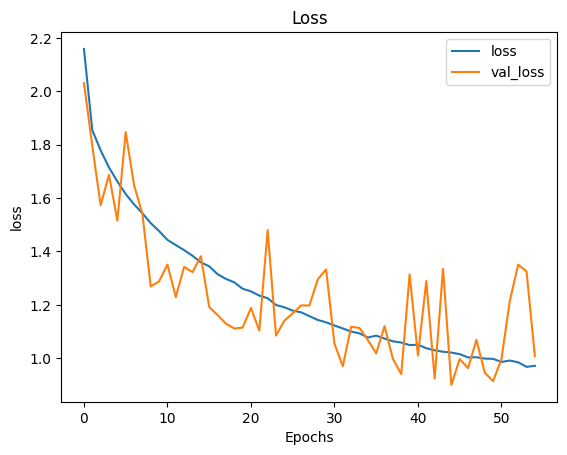

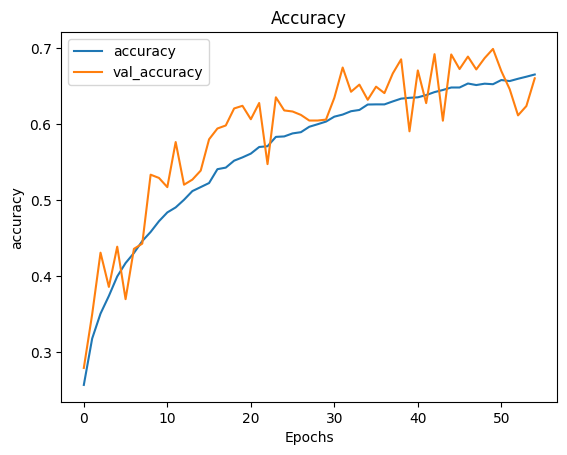

In [ ]:
amount_of_layer_1 = 1
amount_of_layer_2 = 1
amount_of_layer_3 = 1
amount_of_one_dence = 1
amount_of_one_filters = 128

model_layers = [
    layers.Input(shape=(32, 32, 3)),
    data_augmentation
]

for _ in range(amount_of_layer_1):
    model_layers.append(layers.Conv2D(int(amount_of_one_filters), (3, 3), activation='relu', padding='same'))
    model_layers.append(layers.BatchNormalization())
model_layers.append(layers.MaxPooling2D(2, 2))

for _ in range(amount_of_layer_2):
    model_layers.append(layers.Conv2D(int(amount_of_one_filters * 2), (3, 3), activation='relu', padding='same'))
    model_layers.append(layers.BatchNormalization())
model_layers.append(layers.MaxPooling2D(2, 2))
model_layers.append(layers.Dropout(0.3))

for _ in range(amount_of_layer_3):
    model_layers.append(layers.Conv2D(int(amount_of_one_filters * 4), (3, 3), activation='relu', padding='same'))
    model_layers.append(layers.BatchNormalization())
model_layers.append(layers.MaxPooling2D(4, 4))
model_layers.append(layers.Dropout(0.4))

model_layers.append(layers.Flatten())
for _ in range(amount_of_one_dence):
    model_layers.append(layers.Dense(int(amount_of_one_filters * 8), activation='relu'))
model_layers.append(layers.Dropout(0.5))
model_layers.append(layers.Dense(10, activation='softmax'))

model = tf.keras.models.Sequential(model_layers)
model.summary()
# print(model.count_params())
summary_conv_and_last_dense(model)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
            loss=tf.keras.losses.CategoricalCrossentropy(),
            metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=2, name="Top2")])
history = model.fit(train, batch_size=batch_size, epochs=100, validation_data=(val), callbacks=callbacks)
index = np.argmax(history.history['val_loss'])
evaluation = model.evaluate(test)
display_history(history, ['loss', 'val_loss'], "Loss")
display_history(history, ['accuracy', 'val_accuracy'], "Accuracy")

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 38)     │         1,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 32, 32, 38)     │           152 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 32, 32, 38)     │        13,034 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 32, 32, 38)     │           152 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 32, 32, 38)     │        13,034 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 32, 32, 38)     │           152 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 32, 32, 38)     │        13,034 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 32, 32, 38)     │           152 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 16, 16, 38)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 16, 16, 76)     │        26,068 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 16, 16, 76)     │           304 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 16, 16, 76)     │        52,060 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 16, 16, 76)     │           304 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 16, 16, 76)     │        52,060 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 16, 16, 76)     │           304 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 16, 16, 76)     │        52,060 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 16, 16, 76)     │           304 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 8, 8, 76)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 8, 8, 76)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 8, 8, 152)      │       104,12

 Total params: 725,848 (2.77 MB)

 Trainable params: 724,328 (2.76 MB)

 Non-trainable params: 1,520 (5.94 KB)

----------------------------------------------------------------
Layer   Output Shape           Param #
Conv2D  (None, 32, 32, 38)        1064
Conv2D  (None, 32, 32, 38)       13034
Conv2D  (None, 32, 32, 38)       13034
Conv2D  (None, 32, 32, 38)       13034
Conv2D  (None, 16, 16, 76)       26068
Conv2D  (None, 16, 16, 76)       52060
Conv2D  (None, 16, 16, 76)       52060
Conv2D  (None, 16, 16, 76)       52060
Conv2D  (None, 8, 8, 152)       104120
Conv2D  (None, 8, 8, 152)       208088
Dense   (None, 304)             185136
Dense   (None, 10)                3050
Total params: 722808
Epoch 1/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 42s 27ms/step - Top2: 0.3874 - accuracy: 0.2105 - loss: 2.4243 - val_Top2: 0.5365 - val_accuracy: 0.3004 - val_loss: 1.8955
Epoch 2/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 33s 27ms/step - Top2: 0.5352 - accuracy: 0.3047 - loss: 1.8700 - val_Top2: 0.6145 - val_accuracy: 0.3743 - val_loss: 1.7106
Epoch 3/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 34s 27ms/step - Top2: 0.5924 -

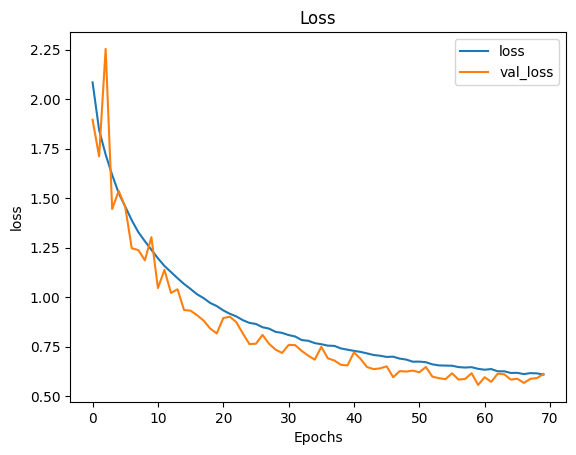

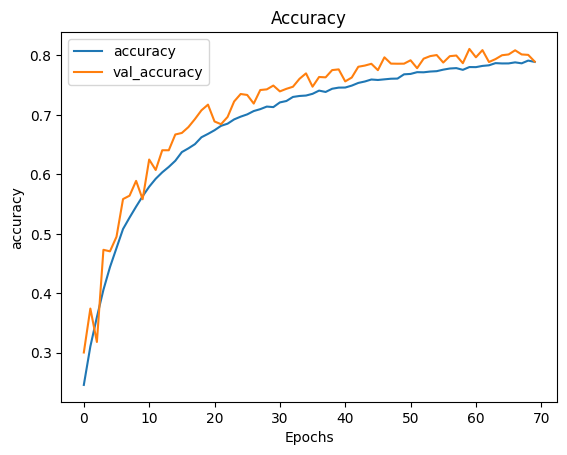

In [ ]:
amount_of_layer_1 = 4
amount_of_layer_2 = 4
amount_of_layer_3 = 2
amount_of_one_dence = 1
amount_of_one_filters = 38

model_layers = [
    layers.Input(shape=(32, 32, 3)),
    data_augmentation
]

for _ in range(amount_of_layer_1):
    model_layers.append(layers.Conv2D(int(amount_of_one_filters), (3, 3), activation='relu', padding='same'))
    model_layers.append(layers.BatchNormalization())
model_layers.append(layers.MaxPooling2D(2, 2))

for _ in range(amount_of_layer_2):
    model_layers.append(layers.Conv2D(int(amount_of_one_filters * 2), (3, 3), activation='relu', padding='same'))
    model_layers.append(layers.BatchNormalization())
model_layers.append(layers.MaxPooling2D(2, 2))
model_layers.append(layers.Dropout(0.3))

for _ in range(amount_of_layer_3):
    model_layers.append(layers.Conv2D(int(amount_of_one_filters * 4), (3, 3), activation='relu', padding='same'))
    model_layers.append(layers.BatchNormalization())
model_layers.append(layers.MaxPooling2D(4, 4))
model_layers.append(layers.Dropout(0.4))

model_layers.append(layers.Flatten())
for _ in range(amount_of_one_dence):
    model_layers.append(layers.Dense(int(amount_of_one_filters * 8), activation='relu'))
model_layers.append(layers.Dropout(0.5))
model_layers.append(layers.Dense(10, activation='softmax'))

model = tf.keras.models.Sequential(model_layers)
model.summary()
# print(model.count_params())
summary_conv_and_last_dense(model)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
            loss=tf.keras.losses.CategoricalCrossentropy(),
            metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=2, name="Top2")])
history = model.fit(train, batch_size=batch_size, epochs=100, validation_data=(val), callbacks=callbacks)
index = np.argmax(history.history['val_loss'])
evaluation = model.evaluate(test)
display_history(history, ['loss', 'val_loss'], "Loss")
display_history(history, ['accuracy', 'val_accuracy'], "Accuracy")

# Plains

## Func

In [ ]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
]

In [ ]:
def func(X):
    amount_of_layer_1 = 4
    amount_of_layer_2 = 4
    amount_of_layer_3 = 2
    amount_of_one_dence = 1
    amount_of_one_filters = int(round(X[0]))
    Dropout = X[1]
    model_layers = [
        layers.Input(shape=(32, 32, 3)),
        data_augmentation
    ]

    for _ in range(amount_of_layer_1):
        model_layers.append(layers.Conv2D(amount_of_one_filters, (3, 3), activation='relu', padding='same'))
        model_layers.append(layers.BatchNormalization())
    model_layers.append(layers.MaxPooling2D(2, 2))

    for _ in range(amount_of_layer_2):
        model_layers.append(layers.Conv2D(amount_of_one_filters * 2, (3, 3), activation='relu', padding='same'))
        model_layers.append(layers.BatchNormalization())
    model_layers.append(layers.MaxPooling2D(2, 2))
    model_layers.append(layers.Dropout(Dropout))

    for _ in range(amount_of_layer_3):
        model_layers.append(layers.Conv2D(amount_of_one_filters * 4, (3, 3), activation='relu', padding='same'))
        model_layers.append(layers.BatchNormalization())
    model_layers.append(layers.MaxPooling2D(4, 4))
    model_layers.append(layers.Dropout(Dropout + 0.1))

    model_layers.append(layers.Flatten())
    for _ in range(amount_of_one_dence):
        model_layers.append(layers.Dense(amount_of_one_filters * 8, activation='relu'))
    model_layers.append(layers.Dropout(Dropout + 0.2))
    model_layers.append(layers.Dense(10, activation='softmax'))

    model = tf.keras.models.Sequential(model_layers)
    summary_conv_and_last_dense(model)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                loss=tf.keras.losses.CategoricalCrossentropy(),
                metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=2, name="Top2")])
    history = model.fit(train, batch_size=batch_size, epochs=100, validation_data=(val), callbacks=callbacks)
    index = np.argmax(history.history['val_loss'])
    evaluation = model.evaluate(test)
    # print(model.metrics_names)
    # print(evaluation)
    loss, acc, top2  = evaluation
    # return (1.0 - history.history['val_accuracy'][index]) + history.history['val_loss'][index]
    return (1.0 - acc) + loss

func_limits = [[16, 64], [0.1, 0.6]]

## Configuration

In [ ]:
dots = 2
x1_lim = func_limits[0]
x1 = np.linspace(x1_lim[0], x1_lim[1], dots)
x2_lim = func_limits[1]
x2 = np.linspace(x2_lim[0], x2_lim[1], dots)
space = np.meshgrid(x1, x2)
space

[array([[16., 64.],
        [16., 64.]]),
 array([[0.1, 0.1],
        [0.6, 0.6]])]

In [ ]:
def wrapped_func(filters, dropout):
    return func(np.array([filters, dropout]))

vectorized_func = np.vectorize(wrapped_func)

fitness = vectorized_func(*space)


----------------------------------------------------------------
Layer   Output Shape           Param #
Conv2D  (None, 32, 32, 16)         448
Conv2D  (None, 32, 32, 16)        2320
Conv2D  (None, 32, 32, 16)        2320
Conv2D  (None, 32, 32, 16)        2320
Conv2D  (None, 16, 16, 32)        4640
Conv2D  (None, 16, 16, 32)        9248
Conv2D  (None, 16, 16, 32)        9248
Conv2D  (None, 16, 16, 32)        9248
Conv2D  (None, 8, 8, 64)         18496
Conv2D  (None, 8, 8, 64)         36928
Dense   (None, 128)              32896
Dense   (None, 10)                1290
Total params: 129402
Epoch 1/100


E0000 00:00:1747294826.577355      35 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_2_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1747294828.964403      94 cuda_dnn.cc:529] Loaded cuDNN version 90300


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 38s 19ms/step - Top2: 0.3578 - accuracy: 0.1925 - loss: 2.2733 - val_Top2: 0.4905 - val_accuracy: 0.2652 - val_loss: 1.9431
Epoch 2/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 22s 18ms/step - Top2: 0.5412 - accuracy: 0.3109 - loss: 1.8367 - val_Top2: 0.5804 - val_accuracy: 0.3501 - val_loss: 1.7692
Epoch 3/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 22s 18ms/step - Top2: 0.6018 - accuracy: 0.3626 - loss: 1.7251 - val_Top2: 0.6182 - val_accuracy: 0.3961 - val_loss: 1.6557
Epoch 4/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 22s 18ms/step - Top2: 0.6373 - accuracy: 0.4039 - loss: 1.6241 - val_Top2: 0.6977 - val_accuracy: 0.4658 - val_loss: 1.4537
Epoch 5/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 22s 18ms/step - Top2: 0.6750 - accuracy: 0.4490 - loss: 1.5307 - val_Top2: 0.6994 - val_accuracy: 0.4781 - val_loss: 1.4392
Epoch 6/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 22s 18ms/step - Top2: 0.6971 - accuracy: 0.4699 - loss: 1.4682 - val_Top2: 0.7002 - val_accuracy: 0.4970 - val_loss: 1.3931
Epoch 7/10

E0000 00:00:1747295312.018751      35 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_3_1/dropout_3_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 34s 18ms/step - Top2: 0.3781 - accuracy: 0.2112 - loss: 2.3080 - val_Top2: 0.5673 - val_accuracy: 0.3334 - val_loss: 1.7819
Epoch 2/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 23s 18ms/step - Top2: 0.5521 - accuracy: 0.3232 - loss: 1.8277 - val_Top2: 0.6164 - val_accuracy: 0.3815 - val_loss: 1.6635
Epoch 3/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 23s 18ms/step - Top2: 0.6103 - accuracy: 0.3731 - loss: 1.7010 - val_Top2: 0.6795 - val_accuracy: 0.4494 - val_loss: 1.4991
Epoch 4/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 22s 18ms/step - Top2: 0.6481 - accuracy: 0.4151 - loss: 1.5962 - val_Top2: 0.6163 - val_accuracy: 0.4115 - val_loss: 1.6992
Epoch 5/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 23s 18ms/step - Top2: 0.6808 - accuracy: 0.4550 - loss: 1.5105 - val_Top2: 0.7285 - val_accuracy: 0.5190 - val_loss: 1.3444
Epoch 6/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 23s 18ms/step - Top2: 0.7050 - accuracy: 0.4820 - loss: 1.4345 - val_Top2: 0.7158 - val_accuracy: 0.4982 - val_loss: 1.4206
Epoch 7/10

E0000 00:00:1747295816.564551      35 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_4_1/dropout_6_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 42s 25ms/step - Top2: 0.4504 - accuracy: 0.2554 - loss: 2.2946 - val_Top2: 0.5593 - val_accuracy: 0.3289 - val_loss: 1.7842
Epoch 2/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - Top2: 0.6037 - accuracy: 0.3706 - loss: 1.7145 - val_Top2: 0.6331 - val_accuracy: 0.4112 - val_loss: 1.6220
Epoch 3/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - Top2: 0.6676 - accuracy: 0.4360 - loss: 1.5474 - val_Top2: 0.7133 - val_accuracy: 0.4956 - val_loss: 1.3873
Epoch 4/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - Top2: 0.7114 - accuracy: 0.4912 - loss: 1.4216 - val_Top2: 0.6667 - val_accuracy: 0.4685 - val_loss: 1.5745
Epoch 5/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - Top2: 0.7364 - accuracy: 0.5231 - loss: 1.3347 - val_Top2: 0.7621 - val_accuracy: 0.5600 - val_loss: 1.2187
Epoch 6/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - Top2: 0.7560 - accuracy: 0.5533 - loss: 1.2734 - val_Top2: 0.7595 - val_accuracy: 0.5712 - val_loss: 1.2272
Epoch 7/10

E0000 00:00:1747296779.689377      35 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_5_1/dropout_9_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 35s 19ms/step - Top2: 0.1991 - accuracy: 0.1012 - loss: 3.7332 - val_Top2: 0.2109 - val_accuracy: 0.1096 - val_loss: 2.3020
Epoch 2/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 23s 18ms/step - Top2: 0.1995 - accuracy: 0.1011 - loss: 2.3099 - val_Top2: 0.2172 - val_accuracy: 0.1149 - val_loss: 2.3044
Epoch 3/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 23s 18ms/step - Top2: 0.1987 - accuracy: 0.0991 - loss: 2.3045 - val_Top2: 0.1964 - val_accuracy: 0.1047 - val_loss: 2.3014
Epoch 4/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 23s 18ms/step - Top2: 0.1973 - accuracy: 0.0994 - loss: 2.3045 - val_Top2: 0.1944 - val_accuracy: 0.0973 - val_loss: 2.3027
Epoch 5/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 23s 18ms/step - Top2: 0.1984 - accuracy: 0.0991 - loss: 2.3041 - val_Top2: 0.1953 - val_accuracy: 0.0979 - val_loss: 2.3025
Epoch 6/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 23s 18ms/step - Top2: 0.1975 - accuracy: 0.0995 - loss: 2.3035 - val_Top2: 0.1937 - val_accuracy: 0.0966 - val_loss: 2.3028
Epoch 7/10

E0000 00:00:1747296977.289691      35 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_6_1/dropout_12_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 42s 25ms/step - Top2: 0.2378 - accuracy: 0.1207 - loss: 3.7072 - val_Top2: 0.4170 - val_accuracy: 0.2108 - val_loss: 2.1158
Epoch 2/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - Top2: 0.3316 - accuracy: 0.1701 - loss: 2.1972 - val_Top2: 0.3227 - val_accuracy: 0.1697 - val_loss: 2.4078
Epoch 3/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 31s 24ms/step - Top2: 0.3573 - accuracy: 0.1819 - loss: 2.1529 - val_Top2: 0.4227 - val_accuracy: 0.2200 - val_loss: 2.0621
Epoch 4/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - Top2: 0.3873 - accuracy: 0.1995 - loss: 2.1212 - val_Top2: 0.4706 - val_accuracy: 0.2524 - val_loss: 1.9481
Epoch 5/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - Top2: 0.4180 - accuracy: 0.2164 - loss: 2.0622 - val_Top2: 0.4822 - val_accuracy: 0.2583 - val_loss: 1.9241
Epoch 6/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - Top2: 0.4590 - accuracy: 0.2428 - loss: 2.0046 - val_Top2: 0.4688 - val_accuracy: 0.2655 - val_loss: 1.9642
Epoch 7/10

/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in wrapped_func (vectorized)
  outputs = ufunc(*inputs)


In [ ]:
fitness

array([[1.40072292, 0.86209428],
       [3.19539705, 2.19910222]])

## Plotting

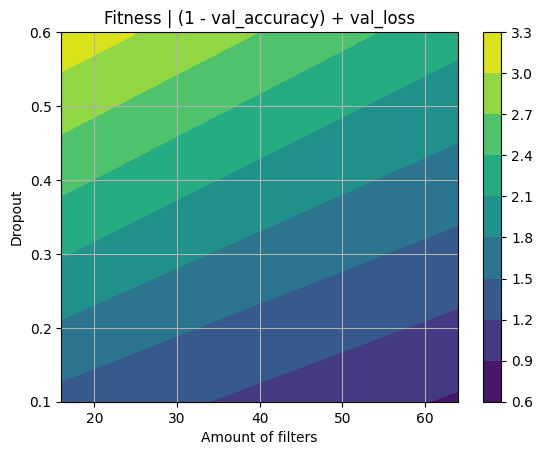

In [ ]:
colorbar = plt.contourf(*space, fitness)
plt.gcf().colorbar(colorbar)
plt.title("Fitness | (1 - val_accuracy) + val_loss")
plt.xlabel("Amount of filters")
plt.ylabel("Dropout")
plt.grid(True)
plt.show()